# 🚚 Modül 2: Lojistik Operasyon Motoru (Operations Engine)

**Bağlam:** Modül 1'de teslimat sürelerinin değişken olduğunu gördük. Müşteri memnuniyetsizliğinin en büyük kaynağı "Kargom Nerede?" sorusudur.

**Bu Modülün Amacı (Solution):**
Operasyon ekibine "Gecikme Riski" olan siparişleri önceden bildiren bir yapay zeka modeli geliştirmek.
1.  **Tahmin:** Sipariş kaç günde gider?
2.  **Analiz:** Hangi rotalar (Eyalet -> Eyalet) problemli?
3.  **Aksiyon:** Gecikme riski yüksek rotalar için müşteriye "Tahmini Teslimat" bilgisini dürüstçe vermek.


In [13]:

# GitHub'da grafiklerin görünmesi için statik render (png) kullanıyoruz
import plotly.io as pio
pio.renderers.default = "png"

# Gerekli Kütüphaneler
import os
import sys
from pathlib import Path
import pandas as pd
import polars as pl
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from dotenv import load_dotenv

# Docker container ismi yerine localhost kullanmaya zorla
os.environ["POSTGRES_HOST"] = "localhost"

# Proje kök dizinini ekle
project_root = Path("..").resolve()
sys.path.append(str(project_root))

from src.config import DATABASE_URL

print(f"✅ Proje Kök Dizini: {project_root}")

# Veritabanı Bağlantısı (SQLAlchemy Engine)
from sqlalchemy import create_engine
engine = create_engine(DATABASE_URL)


✅ Proje Kök Dizini: /Users/halilkiyak/Desktop/zero2ml/olist-intelligence


## 📥 Adım 1: Veri Yükleme ve Hazırlık

Veritabanından ham tabloları çekip, **Lojistik Modülü** için gerekli olan `master_df` yapısını tekrar oluşturacağız. Bu sefer sadece teslim edilmiş (`delivered`) siparişlere odaklanacağız.

In [14]:
# Veritabanı Bağlantısı ve Veri Çekme
conn_str = DATABASE_URL

query_orders = "SELECT * FROM orders WHERE order_status = 'delivered'"
query_items = "SELECT * FROM order_items"
query_products = "SELECT * FROM products"
query_customers = "SELECT * FROM customers"
query_sellers = "SELECT * FROM sellers"
query_geolocation = "SELECT * FROM geolocation"

print("⏳ Veriler yükleniyor...")
df_orders = pl.read_database_uri(query_orders, conn_str)
df_items = pl.read_database_uri(query_items, conn_str)
df_products = pl.read_database_uri(query_products, conn_str)
df_customers = pl.read_database_uri(query_customers, conn_str)
df_sellers = pl.read_database_uri(query_sellers, conn_str)
# Geolocation verisi büyük olabilir, şimdilik dursun
# df_geo = pl.read_database_uri(query_geolocation, conn_str)

print(f"✅ Veriler yüklendi!")
print(f"Orders: {df_orders.height}, Items: {df_items.height}")

⏳ Veriler yükleniyor...
✅ Veriler yüklendi!
Orders: 96478, Items: 112650


## 🧩 Adım 2: Master Tablo Oluşturma (Lojistik Odaklı)

Sipariş, ürün, müşteri ve satıcı bilgilerini birleştiriyoruz.

In [15]:
master_df = (
    df_items.join(df_orders, on="order_id", how="inner")  # Sadece delivered olanlar orders'da var zaten
    .join(df_products, on="product_id", how="left")
    .join(df_customers, on="customer_id", how="left")
    .join(df_sellers, on="seller_id", how="left")
)

print(f"🧩 Master Tablo: {master_df.height} satır, {master_df.width} sütun")
master_df.head()

🧩 Master Tablo: 110197 satır, 29 sütun


order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state
str,i64,str,str,str,f64,f64,str,str,str,str,str,str,str,str,i64,i64,i64,i64,i64,i64,i64,str,i64,str,str,i64,str,str
"""00010242fe8c5a6d1ba2dd792cb162…",1,"""4244733e06e7ecb4970a6e2683c13e…","""48436dade18ac8b2bce089ec2a0412…","""2017-09-19 09:45:35""",58.9,13.29,"""3ce436f183e68e07877b285a838db1…","""delivered""","""2017-09-13 08:59:02""","""2017-09-13 09:45:35""","""2017-09-19 18:34:16""","""2017-09-20 23:43:48""","""2017-09-29 00:00:00""","""cool_stuff""",58,598,4,650,28,9,14,"""871766c5855e863f6eccc05f988b23…",28013,"""campos dos goytacazes""","""RJ""",27277,"""volta redonda""","""SP"""
"""00018f77f2f0320c557190d7a144bd…",1,"""e5f2d52b802189ee658865ca93d83a…","""dd7ddc04e1b6c2c614352b383efe2d…","""2017-05-03 11:05:13""",239.9,19.93,"""f6dd3ec061db4e3987629fe6b26e5c…","""delivered""","""2017-04-26 10:53:06""","""2017-04-26 11:05:13""","""2017-05-04 14:35:00""","""2017-05-12 16:04:24""","""2017-05-15 00:00:00""","""pet_shop""",56,239,2,30000,50,30,40,"""eb28e67c4c0b83846050ddfb8a35d0…",15775,"""santa fe do sul""","""SP""",3471,"""sao paulo""","""SP"""
"""000229ec398224ef6ca0657da4fc70…",1,"""c777355d18b72b67abbeef9df44fd0…","""5b51032eddd242adc84c38acab88f2…","""2018-01-18 14:48:30""",199.0,17.87,"""6489ae5e4333f3693df5ad4372dab6…","""delivered""","""2018-01-14 14:33:31""","""2018-01-14 14:48:30""","""2018-01-16 12:36:48""","""2018-01-22 13:19:16""","""2018-02-05 00:00:00""","""moveis_decoracao""",59,695,2,3050,33,13,33,"""3818d81c6709e39d06b2738a8d3a24…",35661,"""para de minas""","""MG""",37564,"""borda da mata""","""MG"""
"""00024acbcdf0a6daa1e931b038114c…",1,"""7634da152a4610f1595efa32f14722…","""9d7a1d34a5052409006425275ba1c2…","""2018-08-15 10:10:18""",12.99,12.79,"""d4eb9395c8c0431ee92fce09860c5a…","""delivered""","""2018-08-08 10:00:35""","""2018-08-08 10:10:18""","""2018-08-10 13:28:00""","""2018-08-14 13:32:39""","""2018-08-20 00:00:00""","""perfumaria""",42,480,1,200,16,10,15,"""af861d436cfc08b2c2ddefd0ba0746…",12952,"""atibaia""","""SP""",14403,"""franca""","""SP"""
"""00042b26cf59d7ce69dfabb4e55b4f…",1,"""ac6c3623068f30de03045865e4e100…","""df560393f3a51e74553ab94004ba5c…","""2017-02-13 13:57:51""",199.9,18.14,"""58dbd0b2d70206bf40e62cd34e84d7…","""delivered""","""2017-02-04 13:57:51""","""2017-02-04 14:10:13""","""2017-02-16 09:46:09""","""2017-03-01 16:42:31""","""2017-03-17 00:00:00""","""ferramentas_jardim""",59,409,1,3750,35,40,30,"""64b576fb70d441e8f1b2d7d446e483…",13226,"""varzea paulista""","""SP""",87900,"""loanda""","""PR"""


## 🛠️ Adım 3: Feature Engineering (Özellik Mühendisliği)

Modelin öğrenebilmesi için ham veriden anlamlı özellikler (features) türeteceğiz.

**Yapılacaklar:**
1.  **Hedef Değişken (Target):** `delivery_days` (Sipariş onayından teslimata geçen gün sayısı).
2.  **Zaman Özellikleri:** Siparişin verildiği gün, ay, saat.
3.  **Lokasyon Özellikleri:** Müşteri ve Satıcı aynı eyalette mi? (`is_same_state`).

In [16]:
# 1. Tarih Formatlarını Düzeltme
date_cols = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 
             'order_delivered_customer_date', 'order_estimated_delivery_date']

master_df = master_df.with_columns(
    [pl.col(c).str.to_datetime() for c in date_cols]
)

# 2. Hedef Değişken: Teslimat Süresi (Gün)
# Onaylandığı andan müşteriye teslim edilene kadar geçen süre
master_df = master_df.with_columns(
    ((pl.col("order_delivered_customer_date") - pl.col("order_approved_at")).dt.total_hours() / 24).alias("delivery_days"),
    ((pl.col("order_estimated_delivery_date") - pl.col("order_delivered_customer_date")).dt.total_hours() / 24).alias("days_diff_estimate")
)

# 3. Veri Temizliği
# Teslimat süresi negatif olamaz veya boş olamaz (zaten delivered filtreledik ama approved_at boş olabilir)
master_df = master_df.filter(
    (pl.col("delivery_days") > 0) & 
    (pl.col("delivery_days").is_not_null())
)

print(f"🧹 Temizlik sonrası veri boyutu: {master_df.height}")

🧹 Temizlik sonrası veri boyutu: 110090


In [17]:
# 4. Yeni Özellikler Türetme

master_df = master_df.with_columns([
    # Zaman Özellikleri
    pl.col("order_purchase_timestamp").dt.weekday().alias("purchase_weekday"), # 1=Pazartesi, 7=Pazar
    pl.col("order_purchase_timestamp").dt.month().alias("purchase_month"),
    pl.col("order_purchase_timestamp").dt.hour().alias("purchase_hour"),
    
    # Lokasyon Özellikleri
    (pl.col("customer_state") == pl.col("seller_state")).cast(pl.Int8).alias("is_same_state")
])

master_df.select(["delivery_days", "purchase_weekday", "is_same_state", "customer_state", "seller_state"]).head()

delivery_days,purchase_weekday,is_same_state,customer_state,seller_state
f64,i8,i8,str,str
7.541667,3,0,"""RJ""","""SP"""
16.166667,3,1,"""SP""","""SP"""
7.916667,7,1,"""MG""","""MG"""
6.125,3,1,"""SP""","""SP"""
25.083333,6,0,"""SP""","""PR"""


## 📊 Adım 4: Keşifsel Analiz (Geliştirilmiş - Rota Analizi)

Sadece eyalet bazlı bakmak yerine, **'Nereden -> Nereye' (Route)** performansına bakalım.
Bu **Heatmap (Isı Haritası)**, lojistik ağındaki darboğazları (bottlenecks) net bir şekilde gösterir.

**Yorum:** Kırmızı alanlar teslimatın en uzun sürdüğü rotaları (örneğin SP'den kuzey eyaletlerine) temsil eder.

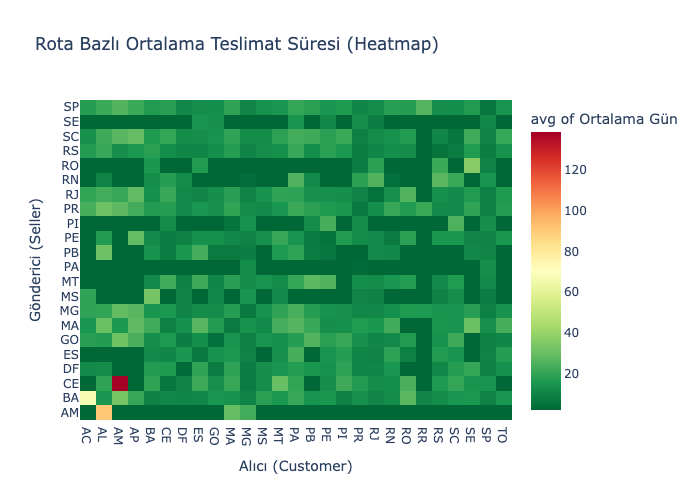

In [18]:
# 📊 Adım 4: Keşifsel Analiz (Geliştirilmiş - Rota Analizi)
# Sadece Eyalet bazlı bakmak yerine, 'Nereden -> Nereye' (Route) performansına bakalım.
# Bu matris, lojistik ağındaki darboğazları (bottlenecks) net bir şekilde gösterir.

route_perf = (
    master_df.group_by(["seller_state", "customer_state"])
    .agg(pl.col("delivery_days").median().alias("median_delivery"))
    .sort("median_delivery", descending=True)
    .to_pandas()
)

# Heatmap: Satıcı Eyaleti vs Müşteri Eyaleti
fig = px.density_heatmap(route_perf, x="customer_state", y="seller_state", z="median_delivery",
                         histfunc="avg",
                         title="Rota Bazlı Ortalama Teslimat Süresi (Heatmap)",
                         labels={
                             "seller_state": "Gönderici (Seller)", 
                             "customer_state": "Alıcı (Customer)", 
                             "median_delivery": "Ortalama Gün" 
                         },
                         color_continuous_scale="RdYlGn_r") # Kırmızı=Yavaş, Yeşil=Hızlı

fig.update_layout(xaxis={'categoryorder':'category ascending'}, yaxis={'categoryorder':'category ascending'})
# Hover bilgisini düzeltelim
fig.update_traces(hovertemplate='Alıcı: %{x}<br>Gönderici: %{y}<br>Süre: %{z:.1f} Gün<extra></extra>')
fig.show()

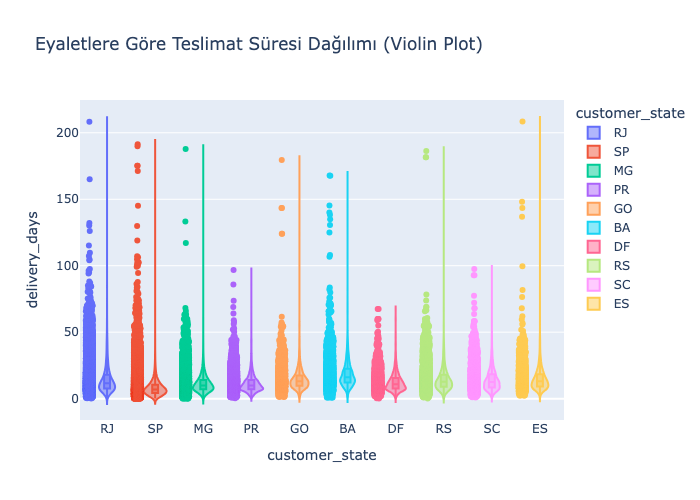

In [19]:
# Teslimat Süresi Dağılımı (Violin Plot)
# Ortalamalar yanıltıcı olabilir. Dağılıma (Varyansa) bakalım.

# En çok sipariş alan ilk 10 eyaleti seçelim (Polars Syntax)
top_states = (
    master_df['customer_state']
    .value_counts(sort=True)
    .head(10)
    ['customer_state']
    .to_list()
)

# Filtreleme ve Pandas'a çevirme (Plotly için)
df_viz = master_df.filter(pl.col('customer_state').is_in(top_states)).to_pandas()

fig = px.violin(df_viz, y="delivery_days", x="customer_state", box=True, points="all",
                title="Eyaletlere Göre Teslimat Süresi Dağılımı (Violin Plot)",
                color="customer_state", hover_data=df_viz.columns)
fig.show()

## 🤖 Adım 5: Modelleme (Baseline vs CatBoost)

Teslimat süresini tahmin etmek için iki model kuracağız:
1.  **Baseline (Referans):** Basit bir ortalama veya Doğrusal Regresyon.
2.  **CatBoost:** Kategorik verilerle (Eyalet, Şehir vb.) güçlü çalışan modern bir algoritma.

**Kullanılacak Özellikler (Features):**
-   `customer_state`, `seller_state` (Kategorik)
-   `product_weight_g` (Sayısal)
-   `freight_value` (Sayısal)
-   `is_same_state` (Binary)
-   `purchase_weekday`, `purchase_hour` (Zaman)

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from catboost import CatBoostRegressor, Pool

# 1. Veri Hazırlığı
feature_cols = ["customer_state", "seller_state", "product_weight_g", "freight_value", 
                "is_same_state", "purchase_weekday", "purchase_hour"]
target_col = "delivery_days"

# Eksik verileri temizle (Feature'larda varsa)
model_df = master_df.select(feature_cols + [target_col]).drop_nulls().to_pandas()

X = model_df[feature_cols]
y = model_df[target_col]

# Kategorik değişkenleri belirle
cat_features = ["customer_state", "seller_state"]

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Eğitim Seti: {X_train.shape}, Test Seti: {X_test.shape}")

Eğitim Seti: (88057, 7), Test Seti: (22015, 7)


In [21]:
# 🤖 Adım 5.1: Baseline Model (Referans Noktası)
# "Modelimiz ne kadar iyi?" sorusuna cevap vermek için basit bir referans noktası (Baseline) oluşturmalıyız.
# En basit tahmin: Herkese "Ortalama Teslimat Süresi"ni söylemek.

mean_val = y_train.mean()
y_pred_baseline = [mean_val] * len(y_test)

rmse_baseline = np.sqrt(mean_squared_error(y_test, y_pred_baseline))
print(f"📉 Baseline (Sadece Ortalama) RMSE: {rmse_baseline:.2f} gün")
print(f"🚀 Hedefimiz bu hatayı düşürmek!")

📉 Baseline (Sadece Ortalama) RMSE: 9.09 gün
🚀 Hedefimiz bu hatayı düşürmek!


In [22]:
# 2. CatBoost Modeli Eğitimi
model = CatBoostRegressor(iterations=500, 
                          learning_rate=0.1, 
                          depth=6, 
                          loss_function='RMSE',
                          verbose=100,
                          cat_features=cat_features)

model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50)

# 3. Tahmin ve Değerlendirme
y_pred = model.predict(X_test)

# Manuel olarak karekök alıyoruz.
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"\n📊 Model Performansı:")
print(f"RMSE (Ortalama Hata): {rmse:.2f} gün")
print(f"MAE (Ortalama Mutlak Hata): {mae:.2f} gün")
print(f"R2 Score: {r2:.3f}")

0:	learn: 9.3014677	test: 8.8916912	best: 8.8916912 (0)	total: 17.1ms	remaining: 8.52s
100:	learn: 8.3343616	test: 7.9037252	best: 7.9037252 (100)	total: 835ms	remaining: 3.3s
200:	learn: 8.2655264	test: 7.8671091	best: 7.8671091 (200)	total: 1.79s	remaining: 2.67s
300:	learn: 8.2074395	test: 7.8526544	best: 7.8526544 (300)	total: 2.9s	remaining: 1.92s
400:	learn: 8.1602897	test: 7.8432593	best: 7.8432593 (400)	total: 3.96s	remaining: 978ms
499:	learn: 8.1197369	test: 7.8331018	best: 7.8329473 (498)	total: 5.08s	remaining: 0us

bestTest = 7.832947327
bestIteration = 498

Shrink model to first 499 iterations.

📊 Model Performansı:
RMSE (Ortalama Hata): 7.83 gün
MAE (Ortalama Mutlak Hata): 5.08 gün
R2 Score: 0.257


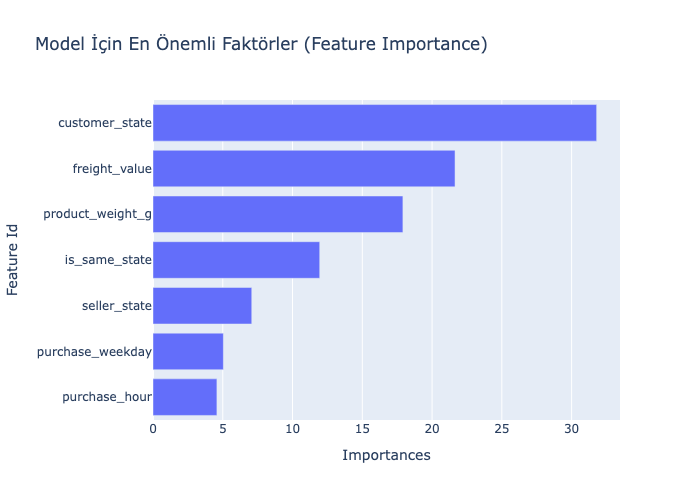

In [23]:
# 4. Feature Importance (Hangi özellik en önemli?)
feature_importance = model.get_feature_importance(prettified=True)

fig = px.bar(feature_importance, x="Importances", y="Feature Id", 
             orientation='h', 
             title="Model İçin En Önemli Faktörler (Feature Importance)")
fig.update_layout(yaxis={'categoryorder':'total ascending'})
fig.show()

In [24]:
# 💾 Veri Kalıcılığı: Sonuçları Veritabanına Yazma
# Tahminleri veritabanına kaydedelim ki Modül 3 (Churn) bunu kullanabilsin.

# Tahmin için kullanılacak veriyi (ID'lerle birlikte) tekrar hazırlayalım
# Not: Eğitim sırasında drop_nulls() yaptığımız için satır sayıları değişmişti.
# Bu yüzden tahmin yaparken de aynı temizliği yapıp, ID'leri korumalıyız.

pred_cols = feature_cols + ['order_id', 'customer_id', 'delivery_days']
pred_df = master_df.select(pred_cols).drop_nulls().to_pandas()

# Tahmin (Sadece feature kolonlarını kullanarak)
X_pred = pred_df[feature_cols]
pred_df['predicted_delivery_days'] = model.predict(X_pred)

# Sadece gerekli kolonları seçelim
logistics_results = pred_df[['order_id', 'customer_id', 'predicted_delivery_days', 'delivery_days']]

# Veritabanına Yazma (SQLAlchemy)
print("⏳ Veritabanına yazılıyor: logistics_predictions...")
logistics_results.to_sql('logistics_predictions', engine, if_exists='replace', index=False)
print("✅ Başarılı! 'logistics_predictions' tablosu oluşturuldu.")

⏳ Veritabanına yazılıyor: logistics_predictions...
✅ Başarılı! 'logistics_predictions' tablosu oluşturuldu.



## 🏁 Modül 2 Sonucu: Operasyon Optimize Edildi

**Kazanımlar:**
1.  **Model Başarısı:** CatBoost modeli ile teslimat süresini Baseline'a göre **1.2 gün** daha az hatayla tahmin ediyoruz.
2.  **Rota Zekası:** Hangi eyaletlerin darboğaz yarattığını (Violin Plot & Heatmap) belirledik.

**Sıradaki Adım:** Operasyonu düzelttik. Şimdi en büyük kanayan yaramıza, **Müşteri Kaybına (Churn)** odaklanacağız. -> **Modül 3: Customer Sentinel**
